In [206]:
import shutil
import os
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

from PIL import Image

from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import torch.utils.data as data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

In [207]:
def load_data_to_df(path):
    imgs = []
    paths = []
    breed  = []
    height, width = [], []

    for folder in tqdm(glob(path)):
        img = cv2.imread(folder)
        imgs.append(img)
        paths.append(folder)
        height.append(img.shape[0])
        width.append(img.shape[1])
        breed.append(folder.split("/")[3].split("-", 1)[1])
    df = pd.DataFrame({'img' : imgs, 'path': paths, 'breed': breed, 'height': height, 'width': width})
    return df

In [208]:
class MyCoolDataset(Dataset):

    def __init__(self, dir, train=True):
        filelist = glob.glob(dir + '/*.png')
        ...
        # all your data loading logic using cv2, glob ..
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=4)

        # two modes - train and test
        if train:
            self.x_data, self.y_data = x_train, y_train
        else:
            self.x_data, self.y_data = x_test, y_test

    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i]

# Define the demo dataset
class DogDataset2(Dataset):
    '''
    Sample dataset for Albumentations demonstration.
    The dataset will consist of just one sample image.
    '''

    def __init__(self, image, augmentations = None):
        self.image = image
        self.augmentations = augmentations # save the augmentations

    def __len__(self):
        return 1 # return 1 as we have only one image

    def __getitem__(self, idx):
        # return the augmented image
        # image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        augmented = self.augmentations(image = self.image)
        return augmented['image']




class datasetloader(Dataset):
    def __init__(self, path, transform=None):
        self.classes   = os.listdir(path)
        self.classes = [i for i in self.classes if not i.startswith('.')]
        self.path      = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform

        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
        return im, classCategory

In [209]:
transform =  A.Compose(
    [
        A.Resize(width=512, height=512),
        A.RandomCrop(width=300, height=300),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ], p=1.0),
        A.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ]
)

In [210]:
df = load_data_to_df("../dataset/Images/*/*")
df['breed'] = df['breed'].str.lower().str.replace("_", " ")

  0%|          | 0/20580 [00:00<?, ?it/s]

In [211]:


# Initialize the dataset, pass the augmentation pipeline as an argument to init function
train_ds = DogDataset2(df["img"].sample(1).values[0], augmentations = transform)

# Initilize the dataloader
trainloader = data.DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

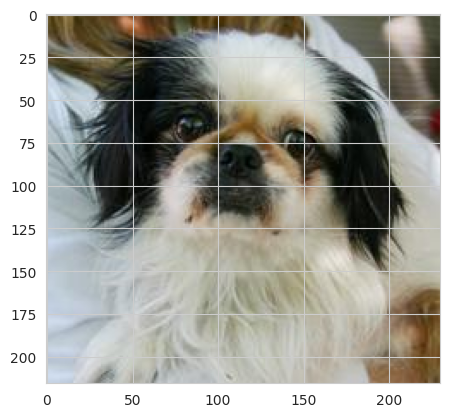

In [212]:
image = Image.fromarray(cv2.cvtColor(df["img"].sample(1).values[0], cv2.COLOR_BGR2RGB)).convert('RGB')
# image = cv2.cv.fromarray(df["img"].sample(1).values[0])
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [213]:
# t = iter(trainloader)
# i = next(t)
# npimg = i.numpy()
# image = Image.fromarray(i.cpu().numpy()).convert('RGB')
# npimg = np.clip(npimg, 0., 1.)
# plt.imshow(image)
# plt.show()

In [214]:
class test1(Dataset):

    def __init__(self, ds, train=True, augmentations=None):
        self.augmentations = augmentations
        x_train, x_test, = train_test_split(
            ds[["img", "breed"]].values, test_size=0.2, random_state=SEED, stratify=ds['breed'])
        # two modes - train and test
        if train:
            self.x_data, self.y_data = x_train, x_test
        else:
            self.x_data, self.y_data = x_test, y_test
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, i):
        return self.x_data[0][i], self.y_data[1][i]


In [215]:
SEED = 42
X = df['img']
y = df['breed']
x_train, x_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=SEED, stratify=df['breed'])


raw_train_data, raw_test_data, = train_test_split(
    df[["img", "breed"]].to_numpy(), test_size=0.2, random_state=SEED, stratify=df['breed'])
# raw_train_data, raw_valid_data, = train_test_split(
#     raw_train_data, test_size=0.1, random_state=SEED, stratify=raw_train_data['breed'])

In [216]:
def split_df(df, rs=SEED):
    Xy = df[["path", "breed"]]
    train, test = train_test_split(
        Xy, test_size=0.2, random_state=rs, stratify=df['breed'])
    train, valid = train_test_split(
        train, test_size=0.1, random_state=rs, stratify=train['breed'])
    return train, test, valid

In [217]:
train, test, valid = split_df(df)

In [218]:
# t = train["breed"].unique()
# t

In [219]:
# t = valid["breed"].unique()
# t

In [220]:
class_map = {key:id for id, key in enumerate(df["breed"].unique())}

class CatsVsDogsDataset(Dataset):
    def __init__(self, ds, class_map=class_map, transform=None):
        self.images_filepaths = ds["path"].to_list()
        self.label = ds["breed"].to_list()
        # self.label_map = {key:id for id, key in enumerate(ds["breed"].unique())}
        self.label_map = class_map
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        class_id = self.label_map[self.label[idx]]
        class_id = torch.tensor(class_id)
        label = self.label[idx]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        # print(self.label_map)
        return image, class_id




In [221]:
mean_std = datasets.ImageFolder(root = "../42_split/train",# loader=,
                                transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in tqdm(mean_std):
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(mean_std)
stds /= len(mean_std)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

  0%|          | 0/14817 [00:00<?, ?it/s]

Calculated means: tensor([0.4765, 0.4523, 0.3909])
Calculated stds: tensor([0.2335, 0.2287, 0.2271])


In [222]:
train_transform = A.Compose(

    [     A.Resize(width=32, height=32),
          # A.RandomCrop(width=30, height=30),
          A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.1),
          A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
          A.OneOf([
              A.Blur(blur_limit=3, p=0.5),
              A.ColorJitter(p=0.5),
          ], p=1.0),
          A.Normalize(
              mean=means,
              std=stds,
              max_pixel_value=255,
          ),
          ToTensorV2(),
          ]

)

In [223]:
# train_transform = A.Compose(
#     [
#         A.Resize(width=32, height=32),
#         A.SmallestMaxSize(max_size=160),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
#         A.RandomCrop(height=128, width=128),
#         A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
#         A.RandomBrightnessContrast(p=0.5),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2(),
#     ]
# )

In [224]:
val_transform = A.Compose(
    [
        A.Resize(width=32, height=32),
        # A.SmallestMaxSize(max_size=160),
        # A.CenterCrop(height=128, width=128),
        A.Normalize(mean=means, std=stds),
        ToTensorV2(),
    ]
)


In [225]:
import copy
def visualize_augmentations(dataset, idx=42, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [226]:
train_dataset = CatsVsDogsDataset(ds=train, transform=train_transform)

In [227]:
val_dataset = CatsVsDogsDataset(ds=valid, transform=val_transform)

In [228]:
test_dataset = CatsVsDogsDataset(ds=test, transform=val_transform)

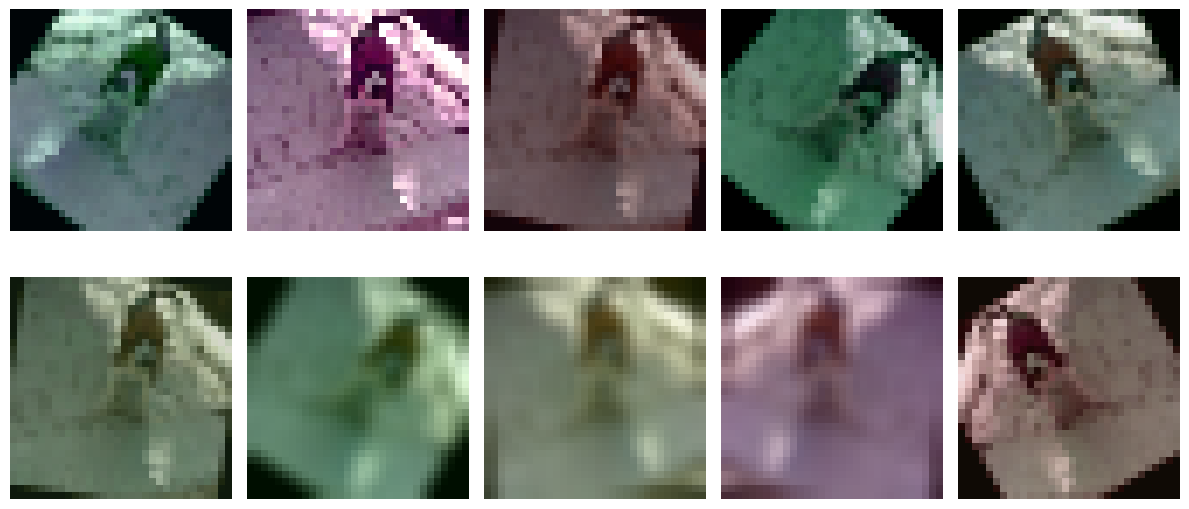

In [229]:
# random.seed(42)
visualize_augmentations(train_dataset)

In [230]:
params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 32,
    "num_workers": 4,
    "epochs": 10,
}

In [231]:
train_loader = data.DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)

test_loader = data.DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = data.DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [232]:
next(iter(train_loader))

[tensor([[[[-2.0409, -2.0409, -2.0409,  ..., -2.0409, -2.0409, -2.0409],
           [-2.0409, -2.0409, -2.0409,  ..., -2.0409, -2.0409, -2.0409],
           [-2.0409, -2.0409, -2.0409,  ..., -2.0409, -2.0409, -2.0409],
           ...,
           [-2.0409, -2.0409, -2.0409,  ..., -2.0409, -2.0409, -2.0409],
           [-2.0409, -2.0409, -2.0409,  ..., -2.0409, -2.0409, -2.0409],
           [-2.0409, -2.0409, -2.0409,  ..., -2.0409, -2.0409, -2.0409]],
 
          [[-1.9778, -1.9778, -1.9778,  ..., -1.9778, -1.9778, -1.9778],
           [-1.9778, -1.9778, -1.9778,  ..., -1.9778, -1.9778, -1.9778],
           [-1.9778, -1.9778, -1.9778,  ..., -1.9778, -1.9778, -1.9778],
           ...,
           [-1.9778, -1.9778, -1.9778,  ..., -1.9778, -1.9778, -1.9778],
           [-1.9778, -1.9778, -1.9778,  ..., -1.9778, -1.9778, -1.9778],
           [-1.9778, -1.9778, -1.9778,  ..., -1.9778, -1.9778, -1.9778]],
 
          [[-1.7211, -1.7211, -1.7211,  ..., -1.7211, -1.7211, -1.7211],
           [-

In [233]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    # Progresses data across layers
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)

        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [234]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=120):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 9 * 9, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 128 * 9 * 9)
        x = self.classifier(x)
        return x

In [235]:
device = params["device"]
net = ConvNet()
net.to(params["device"])
criterion = nn.CrossEntropyLoss()
# also the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=params["lr"], momentum=0.9)

In [245]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(1, 40):  # loop over the dataset multiple times

    running_loss = .0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        # get the inputs
        # inputs, labels = data
        # if device == 'cuda':
        inputs, labels = images.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)

    if epoch % 4 == 0:
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))

    # evaluate on the test set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the test set
    with torch.no_grad():
        correct = 0
        total = 0
        test_running_loss = .0
        for inf in test_loader:
            inputs, labels = inf
            # if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_running_loss /= len(test_loader)
        test_loss.append(test_running_loss)
        test_running_acc = correct / total
        test_acc.append(test_running_acc)

        if epoch % 4 == 0:
            print('Test Acc.  => {:.3f}%'.format(100 * test_running_acc), end=' | ')
            print('Test Loss  => {:.5f}'.format(test_running_loss))

print('Finished Training')


Epoch: 4
Train Acc. => 19.140% | Train Loss => 3.45961
Test Acc.  => 11.249% | Test Loss  => 4.21199

Epoch: 8
Train Acc. => 20.058% | Train Loss => 3.40753
Test Acc.  => 11.127% | Test Loss  => 4.24792

Epoch: 12
Train Acc. => 20.591% | Train Loss => 3.37469
Test Acc.  => 11.638% | Test Loss  => 4.27568

Epoch: 16
Train Acc. => 21.408% | Train Loss => 3.34544
Test Acc.  => 11.322% | Test Loss  => 4.24100

Epoch: 20
Train Acc. => 22.400% | Train Loss => 3.29784
Test Acc.  => 11.200% | Test Loss  => 4.29914

Epoch: 24
Train Acc. => 23.527% | Train Loss => 3.24704
Test Acc.  => 11.492% | Test Loss  => 4.34739

Epoch: 28
Train Acc. => 23.797% | Train Loss => 3.22673
Test Acc.  => 11.346% | Test Loss  => 4.37064

Epoch: 32
Train Acc. => 24.195% | Train Loss => 3.18841
Test Acc.  => 11.322% | Test Loss  => 4.36631

Epoch: 36
Train Acc. => 25.140% | Train Loss => 3.16531
Test Acc.  => 11.419% | Test Loss  => 4.43249
Finished Training


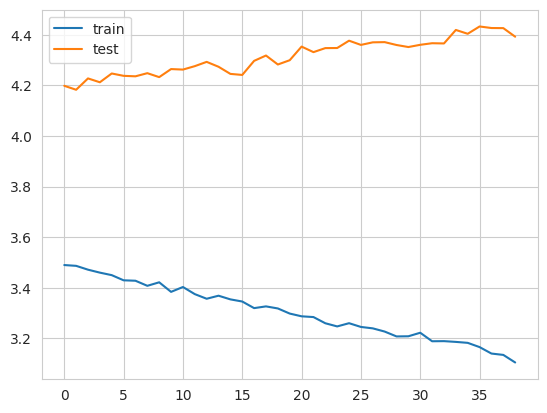

In [246]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

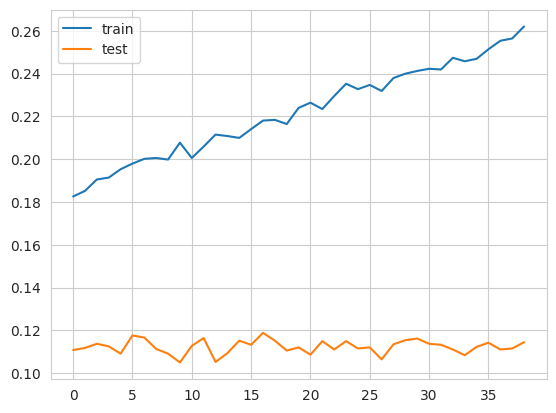

In [247]:
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()
plt.show()